# Чемпионат московской области (цифровой прорыв 2022)

В последние несколько лет большое внимание уделяется развитию малого и среднего бизнеса. Одной из мер поддержки является дополнительное образование для предпринимателей в формате курсов, лекций, тематических игр и бизнес-симуляций.

В данном проекте нам необходимо разработать и обучить модель машинного обучения на основе метаданных поведения пользователя в игре (лог принятых решений пользователей в играх) и его итоговой экспертной оценки. В будущем это позволит проставлять оценки участникам симуляции без привлечения экспертов.

In [103]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn import tree
import numpy as np
from sklearn.metrics import recall_score
from tqdm import tqdm
from catboost import CatBoostClassifier
import warnings

In [104]:
warnings.filterwarnings('ignore')

## Предварительный анализ датасетов

Откроем обучающие данные и все логи и проанализируем их. Начнём с обучающего датасета.

In [105]:
df_train_dataset_train = pd.read_csv('train_dataset_train.csv')
df_train_dataset_train.head(5)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10884,4.0,4.0,4.0,4.0
1,10106,5.0,4.0,5.0,5.0
2,10438,6.0,5.0,5.0,5.0
3,10130,5.0,4.0,5.0,5.0
4,10667,4.0,5.0,5.0,5.0


Посмотрим размер и количество уникальных id  в данном датасете

In [106]:
df_train_dataset_train.shape

(680, 5)

In [107]:
len(df_train_dataset_train['id'].unique())

680

Оценим разброс оценок и примерное распределение по каждому из навыков

In [155]:
df_train_dataset_train['Analytical thinking'].value_counts()

4.0    417
5.0    209
3.0     36
6.0     14
1.0      4
Name: Analytical thinking, dtype: int64

Шкала оценивания по данном навыку лежит в диапазоне от 1 до 6. Построим гистограмму чтобы оценить распределние данного навыка.

Text(0, 0.5, 'Количество оценок')

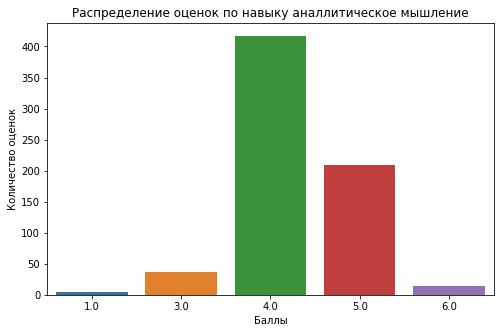

In [109]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Analytical thinking', data=df_train_dataset_train)
plt.title('Распределение оценок по навыку аналлитическое мышление')
plt.xlabel('Баллы')
plt.ylabel('Количество оценок')

Как видно из данных, больше всего ставят 4 и 5 балов за аналитическое мышление, крайне редко данный навык оценивают ниже 3 баллов.

Для остальных навыков будем стротиь только гистограммы. Шкала оценивания, наверняка совпадает.

Text(0, 0.5, 'Количество оценок')

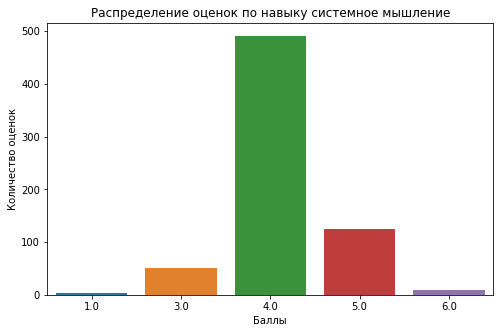

In [110]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Systemic thinking', data=df_train_dataset_train)
plt.title('Распределение оценок по навыку системное мышление')
plt.xlabel('Баллы')
plt.ylabel('Количество оценок')

По системному мышлению распредление баллов ближе к нормальному, но также сохраняется тенденция. что чаще всего игроки получают 4 бала.

Text(0, 0.5, 'Количество оценок')

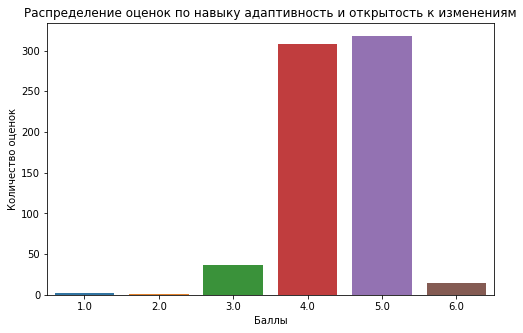

In [111]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Adaptability', data=df_train_dataset_train)
plt.title('Распределение оценок по навыку адаптивность и открытость к изменениям')
plt.xlabel('Баллы')
plt.ylabel('Количество оценок')

По навыку адаптивность и открытость к изменениям в отличии от двх предыдущих чаще ставят 5 балов, немного реже получают 4 бала, остальные оценки ставят значительно реже.

Text(0, 0.5, 'Количество оценок')

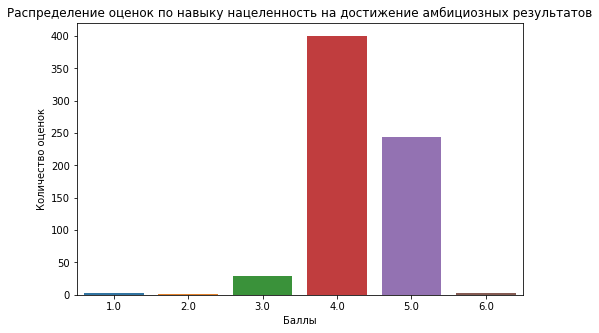

In [112]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Focus', data=df_train_dataset_train)
plt.title('Распределение оценок по навыку нацеленность на достижение амбициозных результатов')
plt.xlabel('Баллы')
plt.ylabel('Количество оценок')

Распределение оценок по навыку нацеленность на достижение амбициозных результатов, близко к распределению аналитического мышления. Нужно проверить коррелируются ли между собой все навыки

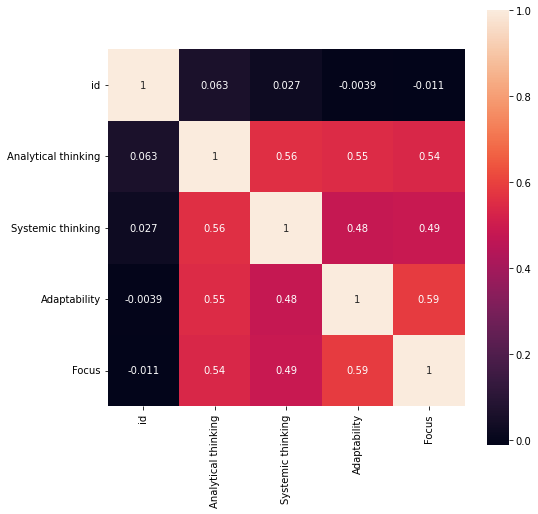

In [113]:
plt.figure(figsize=(8, 8))
g = sns.heatmap(df_train_dataset_train.corr(), square = True, annot=True)

Аналитическое мышление коррелируется почти со всеми навыками, адаптация с нацеленностью на достижение амбициозных результатов. А системное мышление немного хуже коррелируется с адаптацией и нацеленностью на амбициозный результат.

Исходя из полученных данных будем работать с многоклассовой классификацией. При этом для каждого навыка будем обучать отдельную модель.

Изучим файл user.csv

In [114]:
df_user = pd.read_csv('user.csv')
df_user.head(5)

,user_id,team_id,game_id
0,10189,1664,235
1,10018,1690,237
2,10580,1394,194
3,10600,1908,262
4,10112,1592,219


In [115]:
df_user.shape

(973, 3)

In [116]:
len(df_user['user_id'].unique())

973

Количество уникальных id в общем своде игроков больше, чем в тренировочной таблице. Проверим все ли игроки из тренировочного датасета есть в user.

In [117]:
df_train_dataset_train[df_train_dataset_train['id'].isin(df_user['user_id'])].shape

(680, 5)

Действительно все записи по тренировочной выборке находятся в датасете user. Вероятнее всего оставшаяся часть это тестовый набор. Откроем файл sample_solution.csv посмотрим какие пользователи указаны в данном файле, их количество и наличие в таблице user

In [118]:
df_sample_solution = pd.read_csv('sample_solution.csv')
df_sample_solution.head(5)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10199,0,0,0,0
1,10539,0,0,0,0
2,10174,0,0,0,0
3,10465,0,0,0,0
4,10066,0,0,0,0


In [119]:
df_sample_solution.shape

(293, 5)

In [120]:
len(df_sample_solution['id'].unique())

293

In [121]:
df_sample_solution[df_sample_solution['id'].isin(df_user['user_id'])].shape

(293, 5)

Действительно, оставшиеся строки относятся к тестовому набору. Лишних строк в df_user нет

В самой таблице df_user есть неинформтивный столбец game_id удалим его

In [122]:
df_user = df_user.drop('game_id', axis=1)

### Выделение тренировочного и тестового набора. 

Выделим выборку для обучения и финальную для загрузки на сайт

In [123]:
X_train = df_user[df_user['user_id'].isin(df_train_dataset_train['id'])]
X_final_test = df_user[df_user['user_id'].isin(df_sample_solution['id'])]

Поскольку порядок оценок в тренировочной выборке и сами данные в этой выборке может не совпадать, то соединим два этих датасета

In [124]:
# переименование столбца для дальнейшего merge
df_train_dataset_train = df_train_dataset_train.rename(columns = {'id':'user_id'})
X_train = X_train.merge(df_train_dataset_train, on='user_id', how='left')  

Выделим таргеты,упорядоченные с основным датасетом

In [125]:
y_analytical = X_train['Analytical thinking']
y_systemic = X_train['Systemic thinking']
y_adaptability = X_train['Adaptability']
y_focus = X_train['Focus']
X_train = X_train.drop(['Analytical thinking', 'Systemic thinking', 'Adaptability', 'Focus'], axis=1)

Разделим выборку на тренировочную, валидационную и тестовую

In [126]:
(X_train, X_val, 
y_analytical_train, y_analytical_val,
y_systemic_train, y_systemic_val,
y_adaptability_train, y_adaptability_val,
y_focus_train, y_focus_val) = train_test_split(X_train, y_analytical, y_systemic, 
                                               y_adaptability, y_focus,
                                              test_size=0.4,
                                              random_state=159)

In [127]:
(X_val, X_test, 
y_analytical_val, y_analytical_test,
y_systemic_val, y_systemic_test,
y_adaptability_val, y_adaptability_test,
y_focus_val, y_focus_test) = train_test_split(X_val,  y_analytical_val, y_systemic_val, 
                                              y_adaptability_val, y_focus_val,
                                              test_size=0.5,
                                              random_state=159)

### Анализ признаков и объединение датасетов

Откроем датасет user_decision.csv

In [129]:
df_user_decision = pd.read_csv('user_decision.csv')
df_user_decision.head(5)

,user_id,period,decision_id
0,10625,1,409
1,10318,3,203
2,10775,4,420
3,10236,2,284
4,10130,3,72


In [130]:
df_user_decision.shape

(60228, 3)

In [131]:
len(df_user_decision['user_id'].unique())

973

В данной таблице для каждого игрока выделяется несколько периодов в которые он мог совершать действия. Посмотрим на распределение этих действий.

Text(0, 0.5, 'Количество действий')

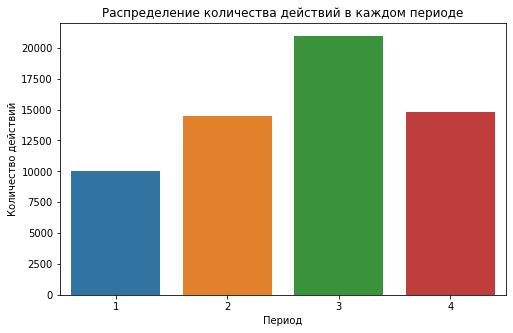

In [132]:
plt.figure(figsize=(8, 5))
sns.countplot(x = 'period' , data  = df_user_decision)
plt.title('Распределение количества действий в каждом периоде')
plt.xlabel('Период')
plt.ylabel('Количество действий')

Больше всего действий было совершено в 3 период. Посмотрим насреднее количество действий игроков в каждый период

Откроем таблицу с действиями decision.xlsx

In [133]:
df_decision = pd.read_excel('decision.xlsx')
df_decision.head(5)

,decision_id,decision_name,Unnamed: 2
0,1,Dividend payout in cash,NaN
1,2,Dividend payout in stocks,NaN
2,3,Zero dividend policy,NaN
3,4,The distribution of the residue after the rein...,NaN
4,5,Fixed size of dividend payouts sum,NaN


Удалим пустой столбец

In [134]:
df_decision = df_decision.drop('Unnamed: 2', axis=1)

In [135]:
df_decision.shape

(437, 2)

Из данных видно, что перечень действий ограничен, соответственно нужно будет свести в одну таблицу Id пользователя, и количество конкретных действий, которые он совершал в каждый из периодов.

In [136]:
# составим список из всех id действий
list_decision = df_decision['decision_id'].unique()
# составим список всех уникальных периодов
list_period = range(1,5)


# функция для добавление в датафрейм столбцов с действиями пользователей
def get_decision_of_user(df, df_user_decision):
    df_new = df.copy(deep=True)
    for period in tqdm(list_period):
        for decision in list_decision:
            df_group_period = (df_user_decision[(df_user_decision['period']==period) & (df_user_decision['decision_id']==decision)]
                       [['user_id', 'decision_id']].groupby(['user_id']).count())
            df_group_period.columns = [ str(period) + '_' + str(decision)]
            df_new = df_new.join(df_group_period, on='user_id')
    df_new = df_new.fillna(0)
    return df_new

Заполним пустые значения 0

In [137]:
X_train = get_decision_of_user(X_train, df_user_decision)
X_val = get_decision_of_user(X_val, df_user_decision)
X_test = get_decision_of_user(X_test, df_user_decision) 
X_final_test = get_decision_of_user(X_final_test, df_user_decision)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.84s/it]


In [138]:
X_train.head(5)

,user_id,team_id,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,...,4_429,4_430,4_431,4_432,4_433,4_434,4_435,4_436,4_437,4_438
616,10421,1732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
266,10212,1378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199,10506,1434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
368,10095,1918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
558,10200,1780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Изучим таблицу с данными о командах team_point.csv

In [139]:
df_team_point = pd.read_csv('team_point.csv')
df_team_point.head(5)

,team_id,category_id,period,score,place
0,1948,2,0,16,2
1,1934,3,4,45,6
2,1894,4,8,24,4
3,1688,4,0,27,4
4,1592,4,2,21,5


In [140]:
df_team_point.shape

(10986, 5)

По первоначальным данным создаётся ощущение, что периоды пользователей и периоды команд не коррелируются(у команд явно есть и 0 и 8 период). Для наглядности выведем диаграмму

Text(0, 0.5, 'Количество оценок')

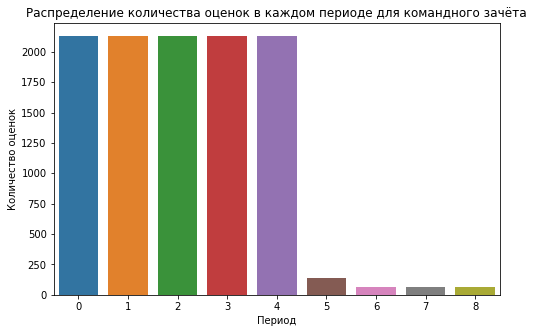

In [141]:
plt.figure(figsize=(8, 5))
sns.countplot(x = 'period' , data  = df_team_point)
plt.title('Распределение количества оценок в каждом периоде для командного зачёта')
plt.xlabel('Период')
plt.ylabel('Количество оценок')

Действительно количество этапов отличается. Крое того начиная с 5 этапа количество участников значительно снижается. Согласно разъяснению организаторов это тренировочные игры и не влияют на оценки игроков. Поэтому удалим их.

In [142]:
df_team_point = df_team_point[df_team_point['period']<5]

Изучим распределение оценок для команд

In [143]:
df_team_point['score'].value_counts()

 27     477
 8      472
 16     435
 4      431
 103    381
       ... 
-75       1
 315      1
 311      1
 293      1
 287      1
Name: score, Length: 406, dtype: int64

Text(0, 0.5, 'Количество оценок')

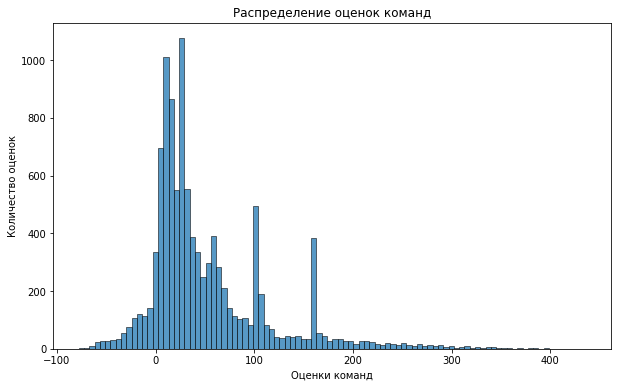

In [144]:
plt.figure(figsize=(10, 6))
sns.histplot(x = 'score' , data  = df_team_point)
plt.title('Распределение оценок команд')
plt.xlabel('Оценки команд')
plt.ylabel('Количество оценок')

Как видно, оценки имеют большой разброс Основная часть сосредоточена в диапазоне от -50 до 200. При этом наблюдаются сильные пики в районе 50, 100 и 150 баллов.

Развернём данную таблицу так чтобы её удобнее было присоединить к таблице пользователей. В конечном результате должна получиться таблица с id команды и со столбцами код_периода_код_категории

In [145]:
# составим список из всех category_id 
list_category_id = df_team_point['category_id'].unique()
# составим список всех уникальных периодов команд
list_period_team = df_team_point['period'].unique()
# создадим датафрейм со столбцом уникальных id команд
df_new_team_point = pd.DataFrame({'team_id': df_team_point['team_id'].unique()})


for period in tqdm(list_period_team):
    for category in list_category_id:
        df_category_period = (df_team_point[(df_team_point['period']==period) & (df_team_point['category_id']==category)]
                   [['team_id', 'score', 'place']])
        df_category_period.columns = ['team_id', 
                                      'score_' + str(period) + '_' + str(category), 
                                      'place_'+str(period) + '_' + str(category)]
        df_new_team_point = df_new_team_point.merge(df_category_period, on='team_id', how='left')  

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 87.90it/s]


In [146]:
df_new_team_point.head(5)

,team_id,score_0_2,place_0_2,score_0_3,place_0_3,score_0_4,place_0_4,score_0_5,place_0_5,score_0_6,...,score_3_3,place_3_3,score_3_4,place_3_4,score_3_5,place_3_5,score_3_6,place_3_6,score_3_1,place_3_1
0,1948,16,2,103,2,27,2,8,2,158,...,59,4,24,5,23,6,83,5,-4,5
1,1934,16,2,103,2,27,2,8,2,158,...,55,5,23,5,26,5,80,4,-6,4
2,1688,16,4,103,4,27,4,8,4,158,...,55,5,22,4,15,6,64,6,-4,5
3,1592,16,2,103,2,27,2,8,2,158,...,65,2,26,2,40,4,187,2,20,1
4,1344,16,6,103,6,27,6,8,6,158,...,61,6,27,5,19,5,117,5,3,5


Заполним пропуски в столбцах. При этом необходимо учесть, что баллы должны заполняться ниже минимальных, а места наоборот выше максимальных значений. 

In [147]:
for column in df_new_team_point.columns:
    if column.count('score') == 1:
        df_new_team_point[column].fillna(df_new_team_point[column].min()-1, inplace=True)
    elif column.count('place') == 1:
        df_new_team_point[column].fillna(df_new_team_point[column].max()+1, inplace=True)

In [148]:
df_new_team_point.head(5)

,team_id,score_0_2,place_0_2,score_0_3,place_0_3,score_0_4,place_0_4,score_0_5,place_0_5,score_0_6,...,score_3_3,place_3_3,score_3_4,place_3_4,score_3_5,place_3_5,score_3_6,place_3_6,score_3_1,place_3_1
0,1948,16,2,103,2,27,2,8,2,158,...,59,4,24,5,23,6,83,5,-4,5
1,1934,16,2,103,2,27,2,8,2,158,...,55,5,23,5,26,5,80,4,-6,4
2,1688,16,4,103,4,27,4,8,4,158,...,55,5,22,4,15,6,64,6,-4,5
3,1592,16,2,103,2,27,2,8,2,158,...,65,2,26,2,40,4,187,2,20,1
4,1344,16,6,103,6,27,6,8,6,158,...,61,6,27,5,19,5,117,5,3,5


Присоединим к первоначальным таблицам таблицу с результатами команд

In [149]:
X_train = X_train.merge(df_new_team_point, on='team_id', how='left')  
X_val = X_val.merge(df_new_team_point, on='team_id', how='left')  
X_test = X_test.merge(df_new_team_point, on='team_id', how='left')  
X_final_test = X_final_test.merge(df_new_team_point, on='team_id', how='left')  

In [150]:
X_train.head(5)

,user_id,team_id,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,...,score_3_3,place_3_3,score_3_4,place_3_4,score_3_5,place_3_5,score_3_6,place_3_6,score_3_1,place_3_1
0,10421,1732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,82,2,29,3,21,5,178,1,16,1
1,10212,1378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,56,4,32,1,57,1,190,1,10,4
2,10506,1434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,43,6,5,6,30,5,-11,6,-26,6
3,10095,1918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,68,2,38,1,36,3,179,2,14,2
4,10200,1780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,52,5,15,5,28,5,35,6,-14,5


Выделим выборку для обучения и финальную для загрузки на сайт

Удалим в датасетах столбцы с id пользователя и команды

In [151]:
X_train = X_train.drop(['user_id', 'team_id'], axis=1)
X_val = X_val.drop(['user_id', 'team_id'], axis=1)
X_test = X_test.drop(['user_id', 'team_id'], axis=1)   

## Создание моделей для предсказания результатов

Для решения данной задачи создадим отдельную модель для предсказания каждого из признаков и подберём оптимальные гиперпараметры для них. После этого обучим все получившиеся модели, проверим их на тестовой выборке и сделаем предсказание на финальном тесте.

### Подбор моделей и оптимальных гиперпараметров

Протестируем несколько моделей и подберём оптимальную для предсказания каждого навыка. Для этого создажим функцию, которая на вход принимает тренировочный и валидационный датасет и находить оптимальные гиперпараметры для ряда, наиболее подходящих моделей.

In [56]:
def get_predicator(X_tr, y_tr, X_v, y_v):
    #SGDClassifier
    lin_clf = SGDClassifier(random_state=159, 
                            penalty='elasticnet', 
                            l1_ratio=0.5)
    lin_clf.fit(X_tr, y_tr)
    y_pred = lin_clf.predict(X_v)
    print('Метрика для SGDClassifier с параметрами по умолчанию', recall_score(y_v, y_pred, average='macro'))
    
    param = {'alpha': np.arange(0.5, 10, 0.5),
             'l1_ratio': np.arange(0.1, 1.1, 0.1)}
    lin_clf = SGDClassifier(random_state=159, 
                             penalty='elasticnet')
    lin_grid_clf = GridSearchCV(lin_clf,
                                       param,     
                                       n_jobs=-1,
                                       cv=3,
                                       scoring='recall_macro',
                                       verbose=False)
    lin_grid_clf.fit(X_tr, y_tr)
    print('Оптимальные параметры для SGDClassifier', lin_grid_clf.best_params_)
    print('Метрика для SGDClassifier на кроссвалидации', lin_grid_clf.best_score_)
    y_pred = lin_grid_clf.best_estimator_.predict(X_v)
    print('Метрика для SGDClassifier с оптимальными параметрами', recall_score(y_v, y_pred, average='macro'))
    print('')
    
    
    #RandomForestClassifier
    rnd_clf_analytical = RandomForestClassifier(random_state=159)
    rnd_clf_analytical.fit(X_tr, y_tr)
    y_pred = rnd_clf_analytical.predict(X_v)
    print('Метрика для RandomForestClassifier с параметрами по умолчанию', recall_score(y_v, y_pred, average='macro'))
   
    param = {'max_depth': range(1, 101, 10), 'n_estimators': range(20, 1001, 20)}
    rnd_clf = RandomForestClassifier(random_state=159)
    rnd_grid_clf = GridSearchCV(rnd_clf,
                           param,
                           n_jobs=-1,
                           cv=3,
                           scoring='recall_macro',
                           verbose=False)
    rnd_grid_clf.fit(X_tr, y_tr)
    print('Оптимальные параметры для RandomForestClassifier', rnd_grid_clf.best_params_)
    print('Метрика для RandomForestClassifier на кроссвалидации', rnd_grid_clf.best_score_)
    y_pred = rnd_grid_clf.best_estimator_.predict(X_v)
    print('Метрика для RandomForestClassifier с параметрами по умолчанию', recall_score(y_v, y_pred, average='macro'))
    print('')
    
    
    #ExtraTreesClassifier
    extr_clf_analytical = ExtraTreesClassifier(random_state=159)
    extr_clf_analytical.fit(X_tr, y_tr)
    y_pred = extr_clf_analytical.predict(X_v)
    print('Метрика для ExtraTreesClassifier с параметрами по умолчанию', recall_score(y_v, y_pred, average='macro'))
    
    param = {'max_depth': range(1, 101, 10), 'n_estimators': range(20, 1001, 20)}
    ext_clf = ExtraTreesClassifier(random_state=159)
    ext_grid_clf = GridSearchCV(ext_clf,
                           param,
                           n_jobs=-1,
                           cv=3,
                           scoring='recall_macro',
                           verbose=False)
    ext_grid_clf.fit(X_tr, y_tr)
    print('Оптимальные параметры для ExtraTreesClassifier', ext_grid_clf.best_params_)
    print('Метрика для ExtraTreesClassifier на кроссвалидации', ext_grid_clf.best_score_)
    y_pred = ext_grid_clf.best_estimator_.predict(X_v)
    print('Метрика для ExtraTreesClassifier с оптимальными параметрами', recall_score(y_v, y_pred, average='macro'))
    print('')
    
    
    #SVC
    svm_clf_analytical = SVC(random_state=159, probability=True)
    svm_clf_analytical.fit(X_tr, y_tr)
    y_pred = svm_clf_analytical.predict(X_v)
    print('Метрика для SVC с параметрами по умолчанию', recall_score(y_v, y_pred, average='macro'))
    
    param = {'C': np.arange(0.5, 100, 0.5)}
    svm_clf = SVC(random_state=159, probability=True)
    svm_grid_clf = GridSearchCV(svm_clf,
                           param,
                           n_jobs=-1,
                           cv=3,
                           scoring='recall_macro',
                           verbose=False)
    svm_grid_clf.fit(X_tr, y_tr)
    print('Оптимальные параметры для SVC', svm_grid_clf.best_params_)
    print('Метрика для SVC на кроссвалидации', svm_grid_clf.best_score_)
    y_pred = svm_grid_clf.best_estimator_.predict(X_v)
    print('Метрика для SVC с параметрами по умолчанию', recall_score(y_v, y_pred, average='macro'))
    print('')
    
    
    #CatBoostClassifier
    cat_clf = CatBoostClassifier(random_state=159,
                            verbose=False)
    cat_clf.fit(X_tr, y_tr)
    y_pred = cat_clf.predict(X_v)
    recall_score(y_analytical_val, y_pred, average='macro')
    print('Метрика для CatBoostClassifier с параметрами по умолчанию', recall_score(y_v, y_pred, average='macro'))
    
    cat_param = {'iterations': range(20, 1020, 20)}
    cat_clf = CatBoostClassifier(random_state=159,
                                verbose=False)
    cat_grid_clf = GridSearchCV(cat_clf,
                           cat_param,
                           cv=3,
                           scoring='recall_macro',
                           n_jobs=-1,
                           verbose=False)
    cat_grid_clf.fit(X_tr, y_tr)
    print('Оптимальные параметры для CatBoostClassifier', cat_grid_clf.best_params_)
    print('Метрика для CatBoostClassifier на кроссвалидации', cat_grid_clf.best_score_)
    y_pred = cat_grid_clf.best_estimator_.predict(X_v)
    print('Метрика для CatBoostClassifier с параметрами по умолчанию', recall_score(y_v, y_pred, average='macro'))
    print('')
    
    
    #VotingClassifier
    estimators = [('rnd', rnd_grid_clf.best_estimator_), 
                  ('extr', ext_grid_clf.best_estimator_), 
                  ('svm', svm_grid_clf.best_estimator_),
                  ('cat', cat_grid_clf.best_estimator_)]
    voting_clf = VotingClassifier(estimators=estimators,
                                         voting='soft')
    voting_clf.fit(X_tr, y_tr)
    y_pred = voting_clf.predict(X_v)
    print('Метрика для VotingClassifier со всеми моделями', recall_score(y_v, y_pred, average='macro'))
    
    for i in range(len(estimators)):
        new_estimators = estimators[:i] + estimators[i+1:]
        voting_clf = VotingClassifier(estimators=new_estimators,
                                         voting='soft')
        voting_clf.fit(X_tr, y_tr)
        y_pred = voting_clf.predict(X_v)
        print(f'Метрика для VotingClassifier без {estimators[i][0]}', recall_score(y_v, y_pred, average='macro'))

In [57]:
get_predicator(X_train, y_analytical_train, X_val, y_analytical_val)

Метрика для SGDClassifier с параметрами по умолчанию 0.27036340852130325
Оптимальные параметры для SGDClassifier {'alpha': 2.5, 'l1_ratio': 0.1}
Метрика для SGDClassifier на кроссвалидации 0.26853175310726446
Метрика для SGDClassifier с оптимальными параметрами 0.2716165413533835

Метрика для RandomForestClassifier с параметрами по умолчанию 0.29448621553884713
Оптимальные параметры для RandomForestClassifier {'max_depth': 31, 'n_estimators': 340}
Метрика для RandomForestClassifier на кроссвалидации 0.24918471833574105
Метрика для RandomForestClassifier с параметрами по умолчанию 0.28728070175438597

Метрика для ExtraTreesClassifier с параметрами по умолчанию 0.30043859649122806
Оптимальные параметры для ExtraTreesClassifier {'max_depth': 41, 'n_estimators': 500}
Метрика для ExtraTreesClassifier на кроссвалидации 0.25975857522509244
Метрика для ExtraTreesClassifier с оптимальными параметрами 0.3208020050125313

Метрика для SVC с параметрами по умолчанию 0.25
Оптимальные параметры для S

In [58]:
get_predicator(X_train, y_systemic_train, X_val, y_systemic_val)

Метрика для SGDClassifier с параметрами по умолчанию 0.30448717948717946
Оптимальные параметры для SGDClassifier {'alpha': 0.5, 'l1_ratio': 1.0}
Метрика для SGDClassifier на кроссвалидации 0.23669045730901397
Метрика для SGDClassifier с оптимальными параметрами 0.2548076923076923

Метрика для RandomForestClassifier с параметрами по умолчанию 0.2467948717948718
Оптимальные параметры для RandomForestClassifier {'max_depth': 31, 'n_estimators': 20}
Метрика для RandomForestClassifier на кроссвалидации 0.21226539783240814
Метрика для RandomForestClassifier с параметрами по умолчанию 0.28365384615384615

Метрика для ExtraTreesClassifier с параметрами по умолчанию 0.3028846153846154
Оптимальные параметры для ExtraTreesClassifier {'max_depth': 31, 'n_estimators': 140}
Метрика для ExtraTreesClassifier на кроссвалидации 0.2124504361617764
Метрика для ExtraTreesClassifier с оптимальными параметрами 0.3028846153846154

Метрика для SVC с параметрами по умолчанию 0.25
Оптимальные параметры для SVC {

In [59]:
get_predicator(X_train, y_adaptability_train, X_val, y_adaptability_val)

Метрика для SGDClassifier с параметрами по умолчанию 0.25208986415882967
Оптимальные параметры для SGDClassifier {'alpha': 4.5, 'l1_ratio': 0.2}
Метрика для SGDClassifier на кроссвалидации 0.30551715309779826
Метрика для SGDClassifier с оптимальными параметрами 0.26201671891327066

Метрика для RandomForestClassifier с параметрами по умолчанию 0.31870428422152564
Оптимальные параметры для RandomForestClassifier {'max_depth': 11, 'n_estimators': 460}
Метрика для RandomForestClassifier на кроссвалидации 0.2828383683222393
Метрика для RandomForestClassifier с параметрами по умолчанию 0.28082549634273773

Метрика для ExtraTreesClassifier с параметрами по умолчанию 0.3359456635318704
Оптимальные параметры для ExtraTreesClassifier {'max_depth': 41, 'n_estimators': 180}
Метрика для ExtraTreesClassifier на кроссвалидации 0.2614908687489333
Метрика для ExtraTreesClassifier с оптимальными параметрами 0.3510971786833856

Метрика для SVC с параметрами по умолчанию 0.27324973876698017
Оптимальные па

In [60]:
get_predicator(X_train, y_focus_train, X_val, y_focus_val)

Метрика для SGDClassifier с параметрами по умолчанию 0.3333333333333333
Оптимальные параметры для SGDClassifier {'alpha': 3.5, 'l1_ratio': 0.2}
Метрика для SGDClassifier на кроссвалидации 0.2617021589302913
Метрика для SGDClassifier с оптимальными параметрами 0.09529356943150047

Метрика для RandomForestClassifier с параметрами по умолчанию 0.41472506989748376
Оптимальные параметры для RandomForestClassifier {'max_depth': 21, 'n_estimators': 1000}
Метрика для RandomForestClassifier на кроссвалидации 0.2618135452237107
Метрика для RandomForestClassifier с параметрами по умолчанию 0.4262193227710469

Метрика для ExtraTreesClassifier с параметрами по умолчанию 0.42218080149114634
Оптимальные параметры для ExtraTreesClassifier {'max_depth': 31, 'n_estimators': 260}
Метрика для ExtraTreesClassifier на кроссвалидации 0.2705065230715349
Метрика для ExtraTreesClassifier с оптимальными параметрами 0.3942218080149115

Метрика для SVC с параметрами по умолчанию 0.3333333333333333
Оптимальные пара

Исходя из полученных данных, оптимальными моделями в первом проходе для каждого из навыков являются слудующие модели:

Для Аналитического мышления ExtraTreesClassifier {'max_depth': 41, 'n_estimators': 500}

Для Системного мышления CatBoostClassifier {'iterations': 240}

Для Адаптивности и открытости к изменениям ExtraTreesClassifier {'max_depth': 41, 'n_estimators': 180}

Для Нацеленности на достижение амбициозных результатов RandomForestClassifier {'max_depth': 21, 'n_estimators': 1000}

Сделаем более тонкий подбор гиперпараметров

#### Чистовой подбор гиперпараметров для Аналитического мышления

На черновом подборе для данного навыка лучший результат показала модель ExtraTreesClassifier с гиперпараметрами: 'max_depth': 41, 'n_estimators': 500. Подберём более точные значения для них использую GridSearchCV с более мелкой сеткой

In [63]:
param = {'max_depth': range(32, 51), 'n_estimators': range(481, 520)}
ext_clf = ExtraTreesClassifier(random_state=159)
ext_grid_clf = GridSearchCV(ext_clf,
                       param,
                       n_jobs=-1,
                       cv=3,
                       scoring='recall_macro',
                       verbose=False)
ext_grid_clf.fit(X_train, y_analytical_train)
print('Оптимальные параметры для ExtraTreesClassifier', ext_grid_clf.best_params_)
print('Метрика для ExtraTreesClassifier на кроссвалидации', ext_grid_clf.best_score_)
y_pred = ext_grid_clf.best_estimator_.predict(X_val)
print('Метрика для ExtraTreesClassifier с оптимальными параметрами', recall_score(y_analytical_val, y_pred, average='macro'))

Оптимальные параметры для ExtraTreesClassifier {'max_depth': 41, 'n_estimators': 495}
Метрика для ExtraTreesClassifier на кроссвалидации 0.2605617880764981
Метрика для ExtraTreesClassifier с оптимальными параметрами 0.3208020050125313


#### Чистовой подбор гиперпараметров для Системного мышления

На черновом подборе для данного навыка лучший результат показала модель CatBoostClassifier с гиперпараметром: 'iterations': 240. Подберём более точные значения для них использую GridSearchCV с более мелкой сеткой

In [76]:
cat_param = {'iterations': range(221, 260)}
cat_clf = CatBoostClassifier(random_state=159,
                            verbose=False)
cat_grid_clf = GridSearchCV(cat_clf,
                       cat_param,
                       cv=3,
                       scoring='recall_macro',
                       n_jobs=-1,
                       verbose=False)
cat_grid_clf.fit(X_train, y_systemic_train)
print('Оптимальные параметры для CatBoostClassifier', cat_grid_clf.best_params_)
print('Метрика для CatBoostClassifier на кроссвалидации', cat_grid_clf.best_score_)
y_pred = cat_grid_clf.best_estimator_.predict(X_val)
print('Метрика для CatBoostClassifier с параметрами по умолчанию', recall_score(y_systemic_val, y_pred, average='macro'))

Оптимальные параметры для CatBoostClassifier {'iterations': 240}
Метрика для CatBoostClassifier на кроссвалидации 0.23823420565688605
Метрика для CatBoostClassifier с параметрами по умолчанию 0.2564102564102564


#### Чистовой подбор гиперпараметров для Адаптивности и открытости к изменениям

На черновом подборе для данного навыка лучший результат показала модель ExtraTreesClassifier с гиперпараметрами: 'max_depth': 41, 'n_estimators': 180. Подберём более точные значения для них использую GridSearchCV с более мелкой сеткой

In [65]:
param = {'max_depth': range(32, 51), 'n_estimators': range(161, 200)}
ext_clf = ExtraTreesClassifier(random_state=159)
ext_grid_clf = GridSearchCV(ext_clf,
                       param,
                       n_jobs=-1,
                       cv=3,
                       scoring='recall_macro',
                       verbose=False)
ext_grid_clf.fit(X_train, y_adaptability_train)
print('Оптимальные параметры для ExtraTreesClassifier', ext_grid_clf.best_params_)
print('Метрика для ExtraTreesClassifier на кроссвалидации', ext_grid_clf.best_score_)
y_pred = ext_grid_clf.best_estimator_.predict(X_val)
print('Метрика для ExtraTreesClassifier с оптимальными параметрами', recall_score(y_adaptability_val, y_pred, average='macro'))

Оптимальные параметры для ExtraTreesClassifier {'max_depth': 40, 'n_estimators': 173}
Метрика для ExtraTreesClassifier на кроссвалидации 0.26473800989930024
Метрика для ExtraTreesClassifier с оптимальными параметрами 0.34352142110762796


#### Чистовой подбор гиперпараметров для Нацеленности на достижение амбициозных результатов

На черновом подборе для данного навыка лучший результат показала модель RandomForestClassifier с гиперпараметрами: 'max_depth': 21, 'n_estimators': 1000. Подберём более точные значения для них использую GridSearchCV с более мелкой сеткой

In [67]:
param = {'max_depth': range(12, 31), 'n_estimators': range(981, 1020)}
rnd_clf = RandomForestClassifier(random_state=159)
rnd_grid_clf = GridSearchCV(rnd_clf,
                       param,
                       n_jobs=-1,
                       cv=3,
                       scoring='recall_macro',
                       verbose=False)
rnd_grid_clf.fit(X_train, y_focus_train)
print('Оптимальные параметры для RandomForestClassifier', rnd_grid_clf.best_params_)
print('Метрика для RandomForestClassifier на кроссвалидации', rnd_grid_clf.best_score_)
y_pred = rnd_grid_clf.best_estimator_.predict(X_val)
print('Метрика для RandomForestClassifier с оптимальными параметрами', recall_score(y_focus_val, y_pred, average='macro'))

Оптимальные параметры для RandomForestClassifier {'max_depth': 21, 'n_estimators': 985}
Метрика для RandomForestClassifier на кроссвалидации 0.2618135452237107
Метрика для RandomForestClassifier с оптимальными параметрами 0.4262193227710469


### Финальное обучение моделей и проверка на тестовом датасете

Объединим трейновый и валидационный датасет и обучим лучшие модели на них.

In [68]:
X_new_train = np.concatenate([X_train, X_val], axis=0)

y_new_analytical_train = pd.concat([y_analytical_train, y_analytical_val], sort=False, axis=0)
y_new_systemic_train = pd.concat([y_systemic_train, y_systemic_val], sort=False, axis=0)
y_new_adaptability_train = pd.concat([y_adaptability_train, y_adaptability_val], sort=False, axis=0)
y_new_focus_train = pd.concat([y_focus_train, y_focus_val], sort=False, axis=0)

In [72]:
model_analytical = ExtraTreesClassifier(random_state=159, max_depth=41, n_estimators=495)
model_analytical.fit(X_new_train, y_new_analytical_train)

model_systemic = CatBoostClassifier(random_state=159, iterations=240,
                                verbose=False)
model_systemic.fit(X_new_train, y_new_systemic_train)

model_adaptability = ExtraTreesClassifier(random_state=159, max_depth=40, n_estimators=173)
model_adaptability.fit(X_new_train, y_new_adaptability_train)

model_focus = RandomForestClassifier(random_state=159, max_depth=21, n_estimators=985)
model_focus.fit(X_new_train, y_new_focus_train)

RandomForestClassifier(max_depth=21, n_estimators=985, random_state=159)

Создадим функцию, для получения датасета в требуемом виде:

In [73]:
def get_predict(X):
    result = pd.DataFrame()
    if 'user_id' in X.columns:
        result['id'] = X['user_id']
        X = X.drop('user_id', axis=1)
    if 'team_id' in X.columns:
        X = X.drop('team_id', axis=1)
    if 'game_id' in X.columns:
        X = X.drop('game_id', axis=1)
        
    result['Analytical thinking'] = model_analytical.predict(X)
    result['Systemic thinking'] = model_systemic.predict(X)
    result['Adaptability'] = model_adaptability.predict(X)
    result['Focus'] = model_focus.predict(X)
    return result

Проверим полученную модель на тестовой выборке

In [77]:
predict = get_predict(X_test)

recall_analytical = recall_score(y_analytical_test, predict['Analytical thinking'], average='macro')
recall_systemic = recall_score(y_systemic_test, predict['Systemic thinking'], average='macro')
recall_adaptability = recall_score(y_adaptability_test, predict['Adaptability'], average='macro')
recall_focus = recall_score(y_focus_test, predict['Focus'], average='macro')

recall_finall = (0.25 * recall_analytical + 0.25 * recall_systemic + 
                 0.25 * recall_adaptability + 0.25 * recall_focus)

print('Метрика на тесте для Analytical thinking', recall_analytical)
print('Метрика на тесте для Systemic thinking', recall_systemic)
print('Метрика на тесте для Adaptability', recall_adaptability)
print('Метрика на тесте для Focus', recall_focus)
print('Финальная метрика на тесте', recall_finall)

Метрика на тесте для Analytical thinking 0.3035714285714286
Метрика на тесте для Systemic thinking 0.25555555555555554
Метрика на тесте для Adaptability 0.3242424242424242
Метрика на тесте для Focus 0.3456221198156682
Финалая метрика на тесте 0.3072478820462691


Метрика на тесте немного ниже чем на трейне. Получим предсказания для финального теста и запишим даные в csv файл

In [152]:
predict = get_predict(X_final_test)
predict.to_csv('predict_chemp_MO_new.csv', index=False)

In [153]:
predict.head(5)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10580,4.0,4.0,5.0,4.0
1,10352,4.0,4.0,4.0,4.0
2,10636,5.0,5.0,5.0,5.0
3,10622,4.0,4.0,4.0,4.0
4,10259,4.0,5.0,5.0,5.0
